# **Image classification:**
one of the key components of computer visions is image claasification . computers which only understand 0 and one how it under stand image data and catgorizes into different classes this what we are going to do in this task.
There are many machine learning and deep learning models and archtectures which which can be deployed to classify images here in this task we will build convolutional neural network
hundreds of applications and fields in which image classification is plyaing role like Ecomerece websites , Anomly detection, health and care trafic regularization and many more but here in this task we will try to classify "cats", "dogs" and "snakes".
About Dataset: This is a publicaly availabe dataset of Animals it contains 3000 images of three classes "cats", "dogs", "snakes" here I am providing link of dataset
"https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset"
now we will move forward to build our pipeline but first we nood some installations to make our enviormnet compatible for our pipeline ane we will import some libraries


In [1]:
%%capture
!wget http://example.com/file.zip
!pip install split-folders[full]
!pip install keras-tuner -q

In [30]:
import warnings
warnings.filterwarnings('ignore')
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import keras
from keras import layers
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import  f1_score


# Uploading dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/Animals/'
exp_dir = '/content/drive/MyDrive/dataset_experiment/'

we will use split folders to create train, validation and test split of our dataset we can do do this with flow from dirctory too but i like split folders for making splits of our data

In [5]:
splitfolders.ratio(data_dir, output=exp_dir,seed=123,
                   ratio=(.7, .15, .15), group_prefix=None, move=True)

Copying files: 2974 files [00:17, 174.86 files/s]


by deploying split folders we created a directory which contains train ,test and validation split below is path to created directory we will use these splits to train our model for validation and testing

In [5]:
train_dir= exp_dir+'/train'
val_dir= exp_dir+'/val'
test_dir= exp_dir+'/test'

# **preprocessing**


now we will remove corruped images from training and validation sets

In [6]:
def remove_corrupted(dir):
    num_skipped = 0
    for folder_name in ("cats", "dogs", "snakes"):
        folder_path = os.path.join(dir, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                with open(fpath, "rb") as fobj:
                    is_jfif = b"JFIF" in fobj.peek(10)
            except Exception as e:
                print(f"error processing file {fpath}: {e}")
                continue
            if not is_jfif:
                num_skipped += 1
                os.remove(fpath)



    return (num_skipped)

In [7]:
remove_corrupted(train_dir)
remove_corrupted(val_dir)


0

now we will load or  use tensorflow image datagenrator for data augmentation here we will resize our images and  encode targets  make our data ready to feed to our model

In [37]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',

)
train_gen = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',

)
val_gen = train_data_gen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',

)


Found 2080 images belonging to 3 classes.
Found 445 images belonging to 3 classes.


now our data is batched, targets indices are maped and hot encoded  

In [41]:
batched_images, batched_labels = next(train_gen)
print(f"shape of batched images:{batched_images.shape}\n shape of batched_label:{batched_labels.shape}")
print(f"train_gen:{train_gen.class_indices}\n val_gen:{val_gen.class_indices}\n labels{batched_labels[:3]}")


shape of batched images:(32, 128, 128, 3)
 shape of batched_label:(32, 3)
train_gen:{'cats': 0, 'dogs': 1, 'snakes': 2}
 val_gen:{'cats': 0, 'dogs': 1, 'snakes': 2}
 labels[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


now we will see our first batch of images here will not that target names are now replaced with class indices

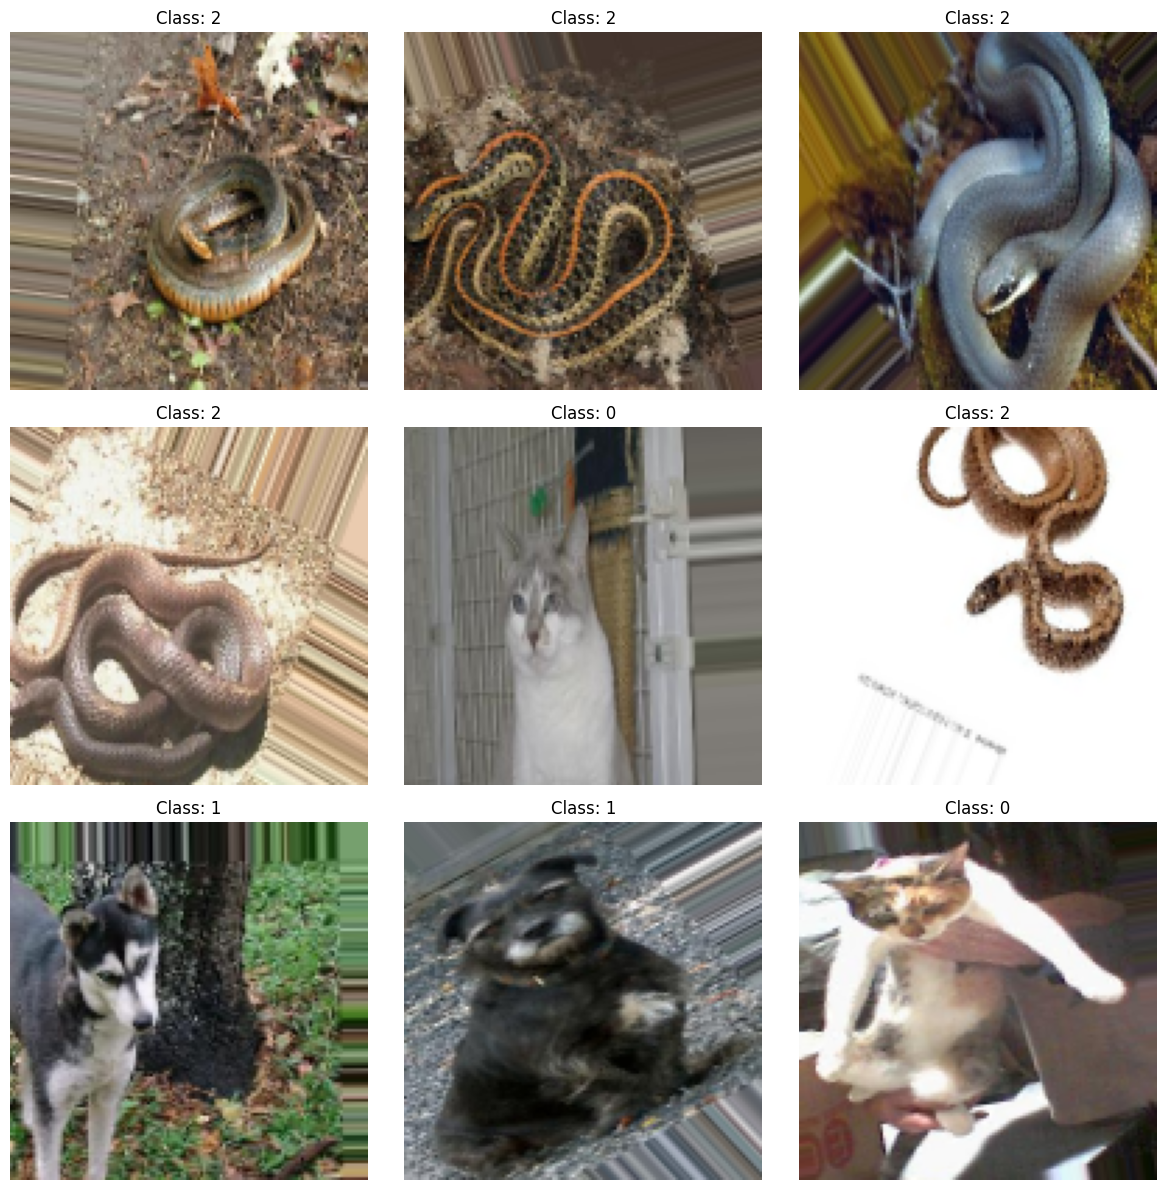

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
for i in range(9):
  ax = axes[i]
  ax.imshow(batched_images[i])
  ax.axis('off')
  ax.set_title(f"Class: {np.argmax(batched_labels[i])}")
plt.tight_layout()
plt.show()

untill now our preprocessing is completed now our data is ready to fed to our model now we will define a search space with keras tuner to find optimal hyperperameters

In [11]:
num_classes = 3
def build_model(hp):
  model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(filters=hp.Int('cnn_units', min_value=32, max_value=128, step=32),
                           kernel_size=3, padding='same', activation='relu',
                           input_shape=(128, 128, 3)),

    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=hp.Int('cnn2_units', min_value=64, max_value=256, step=32),
                           kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(filters=hp.Int('cnn3_units', min_value=128, max_value=512, step=32),
                           kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=hp.Int('den_units', min_value=256, max_value=1024, step=32),
                          activation='relu'),
    tf.keras.layers.Dense(num_classes, activation="softmax")
    ])


  model.compile(optimizer='adam',

                loss='categorical_crossentropy',
                metrics=['accuracy'])




  return model

we defined search space now we will confirm built status

In [12]:
build_model(keras_tuner.HyperParameters())

<Sequential name=sequential, built=True>

now we will initialize tuner with random search

In [13]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',

    max_trials=3,
    directory='my_dir',
    project_name='dog_breed_classifications_datagen_tuner_ani'
)

In [16]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
cnn_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
cnn2_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
cnn3_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
den_units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}


we can tune for learning rate dropout rate or weather to add or remove some layers but here we will only search for cnn layers units and dense units tuner will try different combinations of these perametrs then we will retrive best model among these models and we will build our final model on the best suited perameters for our dataset and model
 now we will start searching these perameters


In [15]:
early_stopping = EarlyStopping(monitor="accuracy",
                               patience=5,
                               restore_best_weights=True)

tuner.search(train_gen,  epochs=10,
             validation_data=val_gen, verbose=0,
             callbacks=[early_stopping])

now we will retrive best hyperperametrs

In [21]:
best_hps = tuner.get_best_hyperparameters(num_trials=3)[0]
best_hps.values

{'cnn_units': 96, 'cnn2_units': 256, 'cnn3_units': 192, 'den_units': 672}

these are best perameters now we will build our model with these peramters to get better predictions

In [22]:
final_model = build_model(best_hps)

In [23]:
final_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 96)        │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 256)         │         221,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 192)         │         442,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 672)                 │      33,030,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           2,019 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,699,523 (128.55 MB)

 Trainable params: 33,699,523 (128.55 MB)

 Non-trainable params: 0 (0.00 B)

In our model there are 9 trainable layers fully connected layers input shape of first layer (128, 128, 3) image width height and 3 RGB chanles final and output layer out put shape 3 corresponding to our tragt classes
now we will start training our model with best hps and we will use early stoping function and will train our model with max numer of epochos as early stoping is there it will stop training when our model stop learning patterns and start memorizing patterns

In [24]:
history_cnn = final_model.fit(train_gen,
                              validation_data=( val_gen),
                              epochs=100,
                              callbacks=[early_stopping],
                              verbose=0, )

Training is completed .now we will check how many epochos did our model run we set epochos values to 100 but we also used early stopnig se we will check

In [25]:
total_epochs = len(history_cnn.epoch)
print(f"total number of epochs run: {total_epochs}")

total number of epochs run: 46


now we will plot training and validation loss and accuracy history

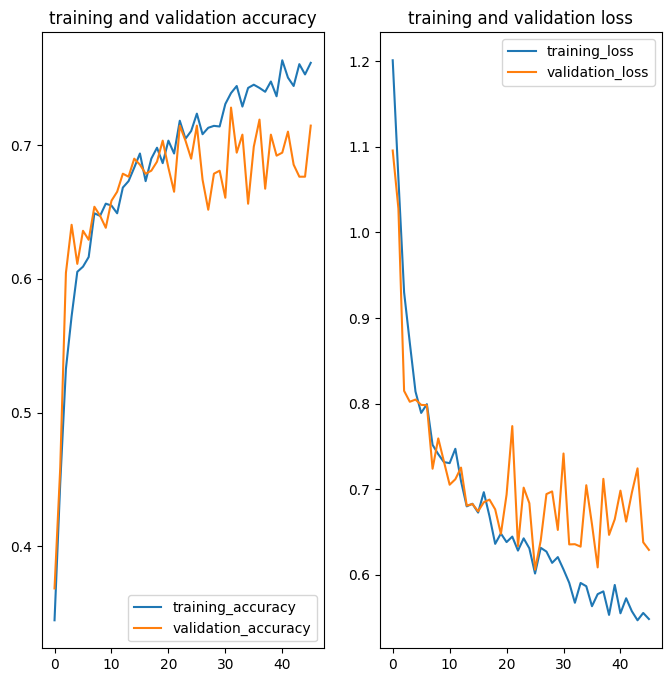

In [28]:
epochs=total_epochs
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='training_accuracy')
plt.plot(epochs_range, val_acc, label='validation_accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='training_loss')
plt.plot(epochs_range, val_loss, label='validation_loss')
plt.legend(loc='upper right')
plt.title('training and validation loss')
plt.show()

by seeing these  images plots we can sau training and validation accuracy increased means our model start learning well but there are more fluctuations in validation accuracy may be caused by over fiting or due to small size of validation data
training and validation loss decreses indicates that our model learned well on training data but on validation data is not performing well as compared to training data
now we will evalute our model on validation data by calculating accuracy and loss metrics

In [35]:
loss, accuracy = final_model.evaluate(val_gen, verbose=0)
print(f"val_accuracy:{accuracy}\n val_loss:{loss}")

val_accuracy:0.7011235952377319
 val_loss:0.6986815929412842


accuracy of 70 % indicates that our model predicts 70 percent of our validation data but almost same loss indicates that model predicts with low confidence
now we will preprocess our test data set

In [38]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),

    class_mode='categorical',
    shuffle=False
)

Found 449 images belonging to 3 classes.


In [39]:
remove_corrupted(test_dir)

0

now we will get predictions on test data set unseen data we will store these predictions in a veriable y_pred then we will plot randomly some predictions

In [29]:
predictions = final_model.predict(test_generator, verbose=0)


y_pred = np.argmax(predictions, axis=1)


y_true = test_generator.classes

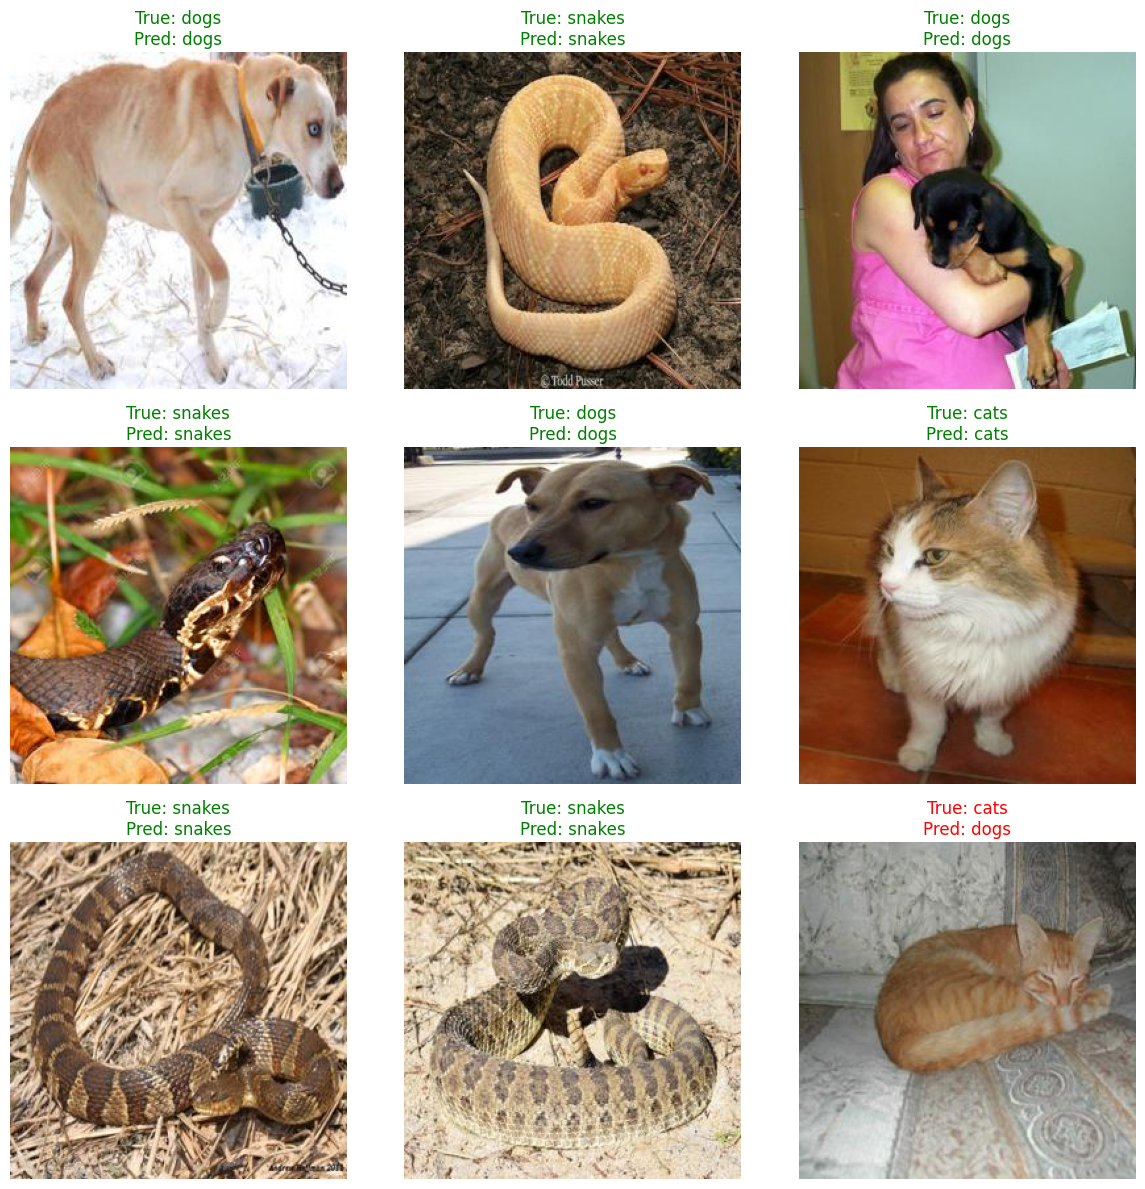

In [36]:
class_labels = list(test_generator.class_indices.keys())

file_paths = test_generator.filepaths

def random_predictions(num_images=9):

    indices = random.sample(range(len(file_paths)), num_images)


    selected_images = [file_paths[i] for i in indices]
    true_labels = [y_true[i] for i in indices]
    pred_labels = [y_pred[i] for i in indices]


    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(num_images):
        img = plt.imread(selected_images[i])
        axes[i].imshow(img)
        axes[i].axis('off')

        axes[i].set_title(
            f"True: {class_labels[true_labels[i]]}\nPred: {class_labels[pred_labels[i]]}",
            color="green" if true_labels[i] == pred_labels[i] else "red"
        )

    plt.tight_layout()
    plt.show()

random_predictions()

now we will evalute our model on test dataset

In [32]:
loss, accuracy = final_model.evaluate(test_generator, verbose=0)
print(f"test_accuracy:{accuracy}\n test_loss:{loss}")

test_accuracy:0.7260578870773315
 test_loss:0.7363759279251099


our model is predictiong almost 73 percent corrctly on unseen data and high loss indicates model predict with low confidance
now we will calculate F1 score to evalute model

In [45]:
f1 = f1_score(y_true, y_pred, average='macro')
print(f"f1_score:{f1}")


f1_score:0.7203450139196086


f1 score of 72 % it means we get moderate results

we build a pipeline for image classification we started from scratch and we get an accuracy of 72+ we confirmed it with dofferent metrixs there is still a lot we can do get more accurate results . A lot we can do in the same pipeline starting from preprocessing bettere we preprocess our data bettter will perform our model  a lot we can do with our model structure changing dropout rate learning rate changing of units and by adding more layers
we can use we can use tranferlearning and pretrained models there are many posibities to get bettere results
